## Predicting Energy Consumption from PJM (in MW)

Will also be comparing energy consumption from the East and West Regions of the United States as well as their projected energy consumption.

#### Functions & Imports

In [2]:
import pandas as pd
import seaborn as sbn
import plotly as plt
import scipy.optimize as sp
import math as m
import numpy as np

In [3]:
def newtint(x, y, xx):
    '''
    Function that uses a Newton Interpolating Polynomial
    Uses n-1 order polynomial given an n amount of data points to
    return a value of the dependent variable => yint at a provided
    independent variable => xx

    Input:
        x => array of independent variables
        y => array of dependent variables
        xx => desired x-value to interpolate

    Output:
        yint => interpolated value at xx
    '''

    # Check if the data is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length.'

    # Initialize holder for calculations -> used to fill with dependent variables
    b = np.zeros((n, n))
    # Assign dependent variables to the 1st column of b for all rows in that column
    b[:, 0] = np.transpose(y)  # switch from input row to input column in b

    # Looping through each value in array to calculate the divided differences
    for j in range(1, n):
        for i in range(n-j):
            # Equation for divided differences based on next and prev points (see slides)
            b[i, j] = (b[i+1, j-1] - b[i, j-1]) / (x[i+j] - x[i])

    xt = 1
    yint = b[0, 0]

    # Solves for yint based on xx and divided differences
    for j in range(n-1):
        xt *= (xx - x[j])
        yint += b[0, j+1] * xt

    return yint

In [4]:
def lagrange(x, y, xx):
    '''
    Lagrange Interpolating Polynomial
    Uses n-1 order lagrange interpolating polynomial based on n number of data points to 
    return a value of the dependent variable yint given the independent variable xx

    Input:
        x => array of independent variable values
        y => array of dependent variable values
        xx => desired independent variable to interpolate

    Output:
        yint => interpolated value
    '''

    # Checking to see if everything is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length'

    # Creating a placeholder
    s = 0

    for i in range(n):
        product = y[i]

        for j in range(n):
            if i != j:
                # This is the weighting equation => L (see slides)
                product *= (xx - x[j]) / (x[i] - x[j])
        s += product

    yint = s
    return yint

In [5]:
# Importing the csv files and assigning them as dataframes
dfw = pd.read_csv('PJMW_hourly.csv')
dfe = pd.read_csv('PJME_hourly.csv')

#### West-region

In [12]:
# Setting values to floats for 'PJMW_MW'
pd.to_numeric(dfw['PJMW_MW'])

used_year_month = [] # Creating list of already used months per year
year_month = 0 # init the year_month iter var

valsPJMW = [] # Temp. list for averaging PJMW_MW vals per year
avg_per_year_month = [] # avg PJMW vals per month
tmpAVG = 0

# Looping through 'dfw' to sort the data by year and create model
for row in dfw.itertuples():
    year_month = row[1][0:7] # ind1 -> tuple key | ind2 -> tuple value
    if year_month in used_year_month:
        valsPJMW.append(row[2])
    elif year_month not in used_year_month: # checks for start of new year
        if not used_year_month: # check for start of loop
            used_year_month.append(year_month) # appends curr year to usedYears list
            continue
        used_year_month.append(year_month) # appends curr year to usedYears list
        tmpAVG = np.average(valsPJMW) # averages PJMW vals per year before clearing valsPJMW
        avg_per_year_month.append(round(tmpAVG, 0))
        valsPJMW.clear() # clears PJMW vals for new year
    
# Global CONSTANT for length of used_year_month to keep consistancy for future arrays
array_length_const = len(used_year_month)

years_list = [] # list of years used for graphing
years_list_curr_val = int(dfw['Datetime'][0][0:4]) # sets current year value to 2002

for i in range(array_length_const): # loops through length of array_length_const
    years_list.append(round(years_list_curr_val, 2)) # appends to the list for graphing
    years_list_curr_val += 1 / 12 # math to add onto the list evenly
years_list.pop(-1) # removes last value from years_list (extra created from loop)

2018.33

Regression, Interpolation, and Visualization

In [41]:
x_Years = np.array(years_list)
y_PJMW = np.array(avg_per_year_month)

p = np.polyfit(years_list, avg_per_year_month, 3) # 2rd order regression
a = p[0] # parameters (coeff) of regression equation -> 1st param
b = p[1] # parameters (coeff) of regression equation -> 2nd param
c = p[2] # parameters (coeff) of regression equation -> 3nd param
d = p[3] # parameters (coeff) of regression equation -> 3nd param

print(years_list)
print(avg_per_year_month)

[2002, 2002.08, 2002.17, 2002.25, 2002.33, 2002.42, 2002.5, 2002.58, 2002.67, 2002.75, 2002.83, 2002.92, 2003.0, 2003.08, 2003.17, 2003.25, 2003.33, 2003.42, 2003.5, 2003.58, 2003.67, 2003.75, 2003.83, 2003.92, 2004.0, 2004.08, 2004.17, 2004.25, 2004.33, 2004.42, 2004.5, 2004.58, 2004.67, 2004.75, 2004.83, 2004.92, 2005.0, 2005.08, 2005.17, 2005.25, 2005.33, 2005.42, 2005.5, 2005.58, 2005.67, 2005.75, 2005.83, 2005.92, 2006.0, 2006.08, 2006.17, 2006.25, 2006.33, 2006.42, 2006.5, 2006.58, 2006.67, 2006.75, 2006.83, 2006.92, 2007.0, 2007.08, 2007.17, 2007.25, 2007.33, 2007.42, 2007.5, 2007.58, 2007.67, 2007.75, 2007.83, 2007.92, 2008.0, 2008.08, 2008.17, 2008.25, 2008.33, 2008.42, 2008.5, 2008.58, 2008.67, 2008.75, 2008.83, 2008.92, 2009.0, 2009.08, 2009.17, 2009.25, 2009.33, 2009.42, 2009.5, 2009.58, 2009.67, 2009.75, 2009.83, 2009.92, 2010.0, 2010.08, 2010.17, 2010.25, 2010.33, 2010.42, 2010.5, 2010.58, 2010.67, 2010.75, 2010.83, 2010.92, 2011.0, 2011.08, 2011.17, 2011.25, 2011.33, 201

In [35]:
def year_vs_PJMW_USWest(x): # defining equation obtained from regression of data
    return a*x**3 + b*x**2 + c*x + d

In [38]:
newPJMWs = [] # temp lists for new PJMWs from regression equation

start_year = 2018 # year to start regression from
end_year = start_year + 16 # year to end regression
new_years = np.linspace(start_year, end_year, 16) # year values as list

for i in range(len(new_years)): # projected PJMWs per year
    new_years[i] = round(new_years[i], 0) # rounding years to whole num
    newPJMWs.append(round(year_vs_PJMW_USWest(round(new_years[i], 0)), 0))
    
regr_avg_per_year_month = np.array(newPJMWs) # convert list to array

[2002.   2002.08 2002.17 2002.25 2002.33 2002.42 2002.5  2002.58 2002.67
 2002.75 2002.83 2002.92 2003.   2003.08 2003.17 2003.25 2003.33 2003.42
 2003.5  2003.58 2003.67 2003.75 2003.83 2003.92 2004.   2004.08 2004.17
 2004.25 2004.33 2004.42 2004.5  2004.58 2004.67 2004.75 2004.83 2004.92
 2005.   2005.08 2005.17 2005.25 2005.33 2005.42 2005.5  2005.58 2005.67
 2005.75 2005.83 2005.92 2006.   2006.08 2006.17 2006.25 2006.33 2006.42
 2006.5  2006.58 2006.67 2006.75 2006.83 2006.92 2007.   2007.08 2007.17
 2007.25 2007.33 2007.42 2007.5  2007.58 2007.67 2007.75 2007.83 2007.92
 2008.   2008.08 2008.17 2008.25 2008.33 2008.42 2008.5  2008.58 2008.67
 2008.75 2008.83 2008.92 2009.   2009.08 2009.17 2009.25 2009.33 2009.42
 2009.5  2009.58 2009.67 2009.75 2009.83 2009.92 2010.   2010.08 2010.17
 2010.25 2010.33 2010.42 2010.5  2010.58 2010.67 2010.75 2010.83 2010.92
 2011.   2011.08 2011.17 2011.25 2011.33 2011.42 2011.5  2011.58 2011.67
 2011.75 2011.83 2011.92 2012.   2012.08 2012.17 20

<Axes: xlabel='Year', ylabel='PJMW'>

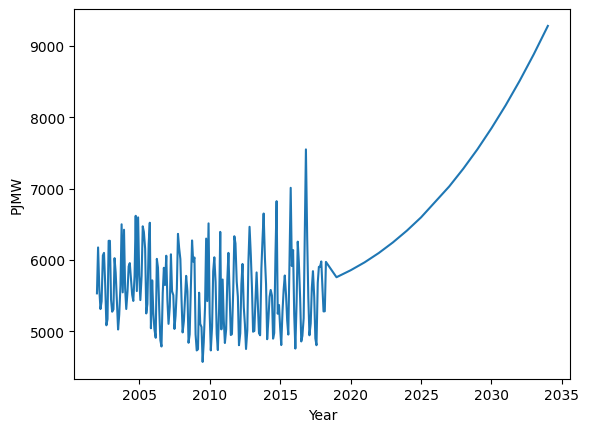

In [39]:
y = np.concatenate( # y-vals of graph -> PJMWs
    (avg_per_year_month, regr_avg_per_year_month),
    axis=0)

x = np.concatenate( # x-vals of graph -> Years
    (x_Years, new_years),
    axis=0
)

print(x)
print(y)

yr_v_pjmw = {'Year':x, 'PJMW':y} # creating dictionary of labeled columns

plotDF = pd.DataFrame(yr_v_pjmw) # creating dataframe from dictionary for plotting

sbn.lineplot(data=plotDF, x='Year', y='PJMW')

#### East-region

In [ ]:
# Using numerical methods to create a model from each dataset
